# Batch Lamda1050 jump correction script and smoothing

### Author: Vinicio Soto, CICIMA
### This script works with raw Lambdas1050's ASC files in batch. It corrects Lambdas1050's detector jump between 857 nm and 858 nm and performs a Savitzky-Golay filtering on the corrected data

### Dependencies

In [1]:
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime

#import spectraltools
#This script requires the file spectraltools.py to work
import sys
# Add the external folder to the system path
current_dir = os.getcwd()
external_folder_path = os.path.abspath(os.path.join(current_dir, '../gamma'))
sys.path.append(external_folder_path)

# Now you can import the Spectrum class from spectrum.py
from spectraltools import get_metadata_and_dataframe

### Instructions:

Write your archive folders' path in file_folder_data_path list

In [2]:
#Lists all archives in folder
file_folder_data_path =[ #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\VENTRAL",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\CICIMA-2024-03-REFLECTANCE\without iris nor lens",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2024-04-INBUCR-REFLECTANCE",
                         #r"C:\Users\EstebanSoto\Jupyter\escarabajos\L1050_data\2023-03-CICIMAUCR-2-REFLECTANCE",
                         r"C:\Users\esteb\cicima\escarabajos\L1050_data\CICIMA-2024-05-REFLECTANCE\DORSAL"
                       ]


### Constants
Define your constants

In [3]:
#determine 
markersize = 1
#date
date = str(datetime.today().date())

### Functions

### Get genera and species function

### Correction process function

In [4]:
def jump_correction(file_folder_data_path, filename, metadata):
    #measuring_mode
    measuring_mode = metadata["measuring_mode"]
    
    #constants
    markersize = 1 #Marker size for plots

    # read text file into pandas DataFrame 
    full_path= file_folder_data_path + "\\" + filename
    
    #Read header
    lines = []
    with open(full_path) as myfile:
        lines = myfile.readlines()[0:90] 
    header = "".join(lines)
    metadata["header"] = header

    #read body
    f = open(full_path)
    df = pd.read_csv(f, sep="\t", decimal = ",", header=90,  
                     names=["wavelength", measuring_mode])
    
    #convert columns to float
    df['wavelength'] = df['wavelength'].astype(float)
    df[measuring_mode] = df[measuring_mode].astype(float)
    

    #This code finds the rows before and after the detector change
    #freq1 is the frequency before the change and freq2 is the frequency after the change
    wavelenght1 = 857.000000 #857
    wavelenght2 = 858.000000 #858
    
    #print("Loc")
    row1 = df.loc[ df['wavelength'] == wavelenght1]
    row2 = df.loc[ df['wavelength'] == wavelenght2]
    row12 = df.loc[ df['wavelength'] == wavelenght1-1]
    row13 = df.loc[ df['wavelength'] == wavelenght1-2]
    row14 = df.loc[ df['wavelength'] == wavelenght1-3]
    row15 = df.loc[ df['wavelength'] == wavelenght1-4]
    
    #This code finds the values corresponding to those frequencies and creates a correction factor
    
    try:
        data1 = row1.iat[0,1]
        data2 = row2.iat[0,1]
        data22 = row12.iat[0,1]
        data23 = row13.iat[0,1]
        data24 = row14.iat[0,1]
        data25 = row15.iat[0,1]
    
        data1_avg = (data1 + data22+data23)/3 #+data24+data25)/5
        data2_avg = (data2)
        correction_factor= data1_avg/data2_avg  
    
        #Multiply all frequencies equal or greater than freq2 by correction_factor
        df2 = df
        df2.loc[df2["wavelength"] >= wavelenght2 , [measuring_mode]] *= correction_factor
        
        
        return df
    except Exception as e:
        
        print(e)
        return pd.DataFrame([])
    
    

In [5]:
def save_corrected_df(df, folder, filename,metadata):
    #variables
    header = metadata["header"]
    
    #convert dataframe to numpy
    my_numpy_df_data = df.to_numpy()
    

    #Create new folder
    
    corrected_path = os.path.join(folder , "jump_corrected_files")

    if not os.path.exists(corrected_path):
        os.mkdir(corrected_path)

    #saves file, removes .ASC and removes .SAMPLE
    unnecessary_text = [".Sample", ".Cycle1"]
    temp_text = filename.replace('.ASC', ''+'.txt')
    
    for text in unnecessary_text:
        #print(temp_text)
        temp_text = temp_text.replace(text, "")

    #new_archive_name = corrected_path + temp_text
    new_archive_name = os.path.join(corrected_path , temp_text)

    with open(new_archive_name, 'wb') as f:
        np.savetxt(new_archive_name, my_numpy_df_data,fmt = "%.6f", delimiter="\t", header=header, comments='', )
    with open(new_archive_name, "r") as f:
        data = f.read()
    with open(new_archive_name, "w") as f:
        f.write(data.replace("#DATA\n","#DATA"))

In [7]:

from scipy.signal import savgol_filter

def savitzky_golay_filter(metadata, df) -> pd.DataFrame:
    """Defines a Savitzky Golay Filter: Basically, smoothes out the function. https://es.wikipedia.org/wiki/Filtro_de_Savitzky%E2%80%93Golay"""
    measuring_mode = metadata["measuring_mode"]
    y = df[measuring_mode] = df[measuring_mode].astype(float)
    
    # Apply Savitzky-Golay filter
    window_length = 21  # Window length (odd number)
    polyorder = 2  # Polynomial order
    y_smooth = savgol_filter(y, window_length, polyorder)
    
    #create new dataframe
    df_smooth = pd.DataFrame([])
    df_smooth["wavelength"] =df["wavelength"]
    df_smooth[measuring_mode] = y_smooth
    
    return df_smooth
    

In [8]:
def filter_list_extension(file_folder_data_path):
    """Only files that end in a particular extension are read"""
    file_list = os.listdir(file_folder_data_path)

    #file extension
    file_extension = ".ASC"

    # filters a list of strings to create a new list containing only the elements that end with ".ASC"

    def filter_substring_elements(path_strings, substring):
        filtered_paths = [path for path in path_strings if substring in path]
        return filtered_paths

    # Filtering elements ending with ".ASC"
    filtered_list = filter_substring_elements(file_list, file_extension)

    # Displaying the filtered list
    #print(filtered_list)
    
    return filtered_list

### Logic: Remove jumps

In [9]:
### First, we will get a list of filenames in the folder
filenames = []
for path in file_folder_data_path: 
    filenames.extend(filter_list_extension(path))

# From this list we will make a set of codes.
#print(filenames)

def get_sample_code(row_str):
        #Tries to get the sample code from the filename
        re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
        
        #Names are in the form CODE-MEASUREMENTNUMBER.TXT
        p = re.compile(re1)
        m = p.match(row_str)

        if m:
            return(m.group(1))
        else:
            ""
codes = []
for filename in filenames:
    codes.append(get_sample_code(filename))
codes = set(codes)
codes

{'CICIMAUCR0201',
 'CICIMAUCR0204',
 'CICIMAUCR0205',
 'CICIMAUCR0209',
 'CICIMAUCR0210',
 'CICIMAUCR0212',
 'CICIMAUCR0213',
 'CICIMAUCR0214',
 'CICIMAUCR0215',
 'CICIMAUCR0223',
 'CICIMAUCR0225',
 'CICIMAUCR0232',
 'CICIMAUCR0233',
 'CICIMAUCR0234',
 'CICIMAUCR0235',
 'CICIMAUCR0236',
 'CICIMAUCR0238',
 'CICIMAUCR0239',
 'CICIMAUCR0240',
 'CICIMAUCR0242',
 'CICIMAUCR0244',
 'CICIMAUCR0245',
 'CICIMAUCR0247',
 'CICIMAUCR0248',
 'CICIMAUCR0250',
 'CICIMAUCR0251',
 'CICIMAUCR0252',
 'CICIMAUCR0253',
 'CICIMAUCR0254',
 'CICIMAUCR0257',
 'CICIMAUCR0258',
 'CICIMAUCR0260',
 'CICIMAUCR0261'}

(filtered_list)=['CICIMAUCR0201-1.Sample.ASC', 'CICIMAUCR0201-2.Sample.ASC', 'CICIMAUCR0201-3.Sample.ASC', 'CICIMAUCR0204-1.Sample.ASC', 'CICIMAUCR0204-2.Sample.ASC', 'CICIMAUCR0204-3.Sample.ASC', 'CICIMAUCR0205-1.Sample.ASC', 'CICIMAUCR0205-2.Sample.ASC', 'CICIMAUCR0205-3.Sample.ASC', 'CICIMAUCR0209-1.ASC', 'CICIMAUCR0209-2.ASC', 'CICIMAUCR0209-3.ASC', 'CICIMAUCR0210-1.ASC', 'CICIMAUCR0210-2.ASC', 'CICIMAUCR0210-3.ASC', 'CICIMAUCR0212-1.ASC', 'CICIMAUCR0212-2.ASC', 'CICIMAUCR0212-3.ASC', 'CICIMAUCR0213-1.Sample.ASC', 'CICIMAUCR0213-2.ASC', 'CICIMAUCR0213-3.ASC', 'CICIMAUCR0213-3.Sample.ASC', 'CICIMAUCR0214-1.ASC', 'CICIMAUCR0214-2.ASC', 'CICIMAUCR0214-2.Sample.ASC', 'CICIMAUCR0214-3.ASC', 'CICIMAUCR0214-3.Sample.ASC', 'CICIMAUCR0215-1.ASC', 'CICIMAUCR0215-2.ASC', 'CICIMAUCR0215-2.Sample.ASC', 'CICIMAUCR0215-3.Sample.ASC', 'CICIMAUCR0223-1.Sample.ASC', 'CICIMAUCR0223-2.Sample.ASC', 'CICIMAUCR0223-3.Sample.ASC', 'CICIMAUCR0225-1.Sample.ASC', 'CICIMAUCR0225-2.Sample.ASC', 'CICIMAUCR0225-

ValueError: could not convert string to float: '#DATA'

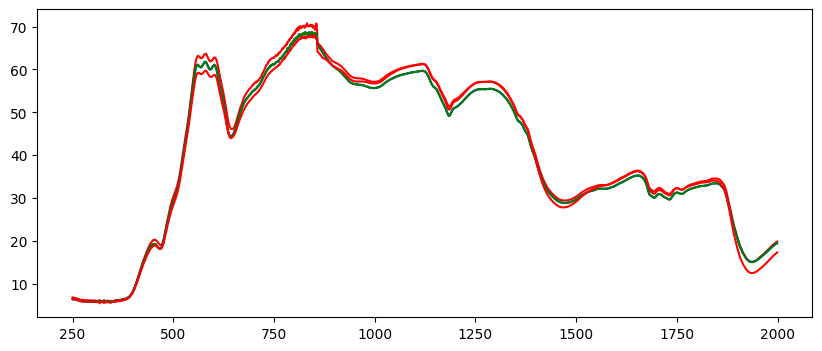

In [11]:
#for each folder location:
jump_corrected_dict = []
file_counter = 0

for folder in file_folder_data_path:
    #create a list of all files in folder
    
    filtered_list = filter_list_extension(folder)
    print(f"{(filtered_list)=}")
    print(f"{len(filtered_list)=}")
    
    #if the folder has an archive called "exclusion_list.txt" read it and remove any file that is in the list
    if "exclusion_list.txt" in os.listdir(folder):
        exclusion_list_filename = os.path.join(folder,"exclusion_list.txt")
        exclusion_list_df = pd.read_csv(exclusion_list_filename, header = 0, names=["filename", "reason"], delimiter = "\t")
        exclusion_list = exclusion_list_df["filename"].values
        for excluded_file in exclusion_list:
            filtered_list = [filename for filename in filtered_list if excluded_file not in filename ]
        
    print(f"{len(filtered_list)=}")
    
    #create a subfolder called report with the correction process info  
    report_path = os.path.join(folder, "report")  

    if not os.path.exists(report_path):
            os.mkdir(report_path)

    new_file = os.path.join( report_path , f'original_data_{date}.pdf')
    
    #create a report in pdf
    with matplotlib.backends.backend_pdf.PdfPages(new_file) as pdf:
        
        for code in codes: 
            #Code by code we will plot all the spectra with the same name
            code_file_counter = 1
            
            files_with_code = [file for file in filtered_list if code in file]
            
            plt.figure(figsize=(10, 4))
            
            for file in files_with_code:
                
                #print(f"{code_file_counter}")
                #obtain metadata
                complete_path = os.path.join(folder, file)
                metadata, df = get_metadata_and_dataframe(complete_path)
                filename = metadata["filename"]

                #After that we will average the spectra
                #create figure
                color = "r"
                if code_file_counter == 2:
                    color = "b"
                elif code_file_counter ==3:
                    color = "g"
                    
                #plots before changes
                #plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
                plt.plot(df["wavelength"], df[metadata["measuring_mode"]], color = color, label = f"{filename}")
                
                #Then they will be jump corrected
                #Fix jump correction
                df_corrected = jump_correction(folder, file, metadata)
                corrected_dict = {"df":df_corrected, "complete_path": complete_path, "metadata": metadata, "code":code}
                
                jump_corrected_dict.append(corrected_dict)
                save_corrected_df(df_corrected, folder, filename, metadata)
                
                code_file_counter += 1
                file_counter += 1
                ### end for
                
            plt.title(f'1. Raw data. {code}')
            plt.ylim(0,100)
            plt.legend()
            plt.grid(True)
            #plt.show()
            pdf.savefig()
            plt.close()
        
        
print(f"{file_counter} files were corrected")

new_file = os.path.join( report_path , f'jump_correction_smoothing_average_report_{date}.pdf')

smooth_dicts = []


with matplotlib.backends.backend_pdf.PdfPages(new_file) as pdf:
    
    for code in codes:
        file_counter = 1
        #get dataframes for each code
        dfs_dict = [element for element in jump_corrected_dict if element["code"] == code]
        #create figure
        plt.figure(figsize=(10, 4))
        
        for dict_i in dfs_dict:
            #print(dict_i["df"],dict_i["complete_path"], dict_i["metadata"])
            df_corrected = dict_i["df"]
            metadata = dict_i["metadata"]
            complete_path = dict_i["complete_path"]
            filename = metadata["filename"]
            
            #color
            color = "r"
            if file_counter== 2:
                color = "b"
            elif file_counter==3:
                color = "g"
            elif file_counter==4:
                color = "y"
                
            #plots changes
            if not df_corrected.empty:
                #plt.subplot(1, 2, 2)
                
                plt.plot(df_corrected["wavelength"], df_corrected[metadata["measuring_mode"]], color = color, label = f'{filename}' )
                plt.grid(True)
                #plt.title(f'2: Jump correction.  {filename}')
                #plt.show()
                #pdf.savefig()
                #plt.close()

                #filter data
                df_smooth = savitzky_golay_filter(metadata, df_corrected)
                smooth_dict = {"df":df_smooth, "complete_path": complete_path, "metadata": metadata, "code":dict_i["code"]}
                smooth_dicts.append(smooth_dict)
                file_counter = file_counter + 1
                
        #plt.show()
        plt.ylim(0,100)
        plt.legend()
        plt.title(f"Jump correction: {code}")
        pdf.savefig()
        plt.close()

        

#calculate averages

In [ ]:
def get_files_with_same_name(directory):
    #get files in directory
    files = os.listdir(directory)
    
    sample_names = []
    re1 = r"([a-zA-Z\d]+)(?:-\d)*(?:.Sample)*.(?:txt)*(?:ASC)*"
    #Names are in the form CODE-MEASUREMENTNUMBER.TXT
    for file in files:
        #print(file)
        p = re.compile(re1)
        m = p.match(file)
        if m:
            sample_names.append(m.group(1))

    return set(sample_names)

In [ ]:
var_dataframes = None
def average_files(code_set, directory, pdf):
    
    #parent directory
    save_directory = os.path.dirname(directory)
    
    #print(f"{save_directory=}")
    
    file_counter = 0

    #Look for every available code in the folder
    for code in code_set:
        print(f"{code=}")

        #Get all files that are in the folder which do not have test or fail
        files = [file for file in os.listdir(directory) if file.endswith('.txt') 
                 and "fail" not in file 
                 and "test" not in file
                 and code in file
                 and len(file)]
        
        #print(files)
        
        # Create an empty list to store dataframes for this code
        dataframes = []
        
        
        # Read each file, create dataframes, and plot them
        for file in files:
            print(f"{file=}")
            #file path
            file_path = os.path.join(directory, file)

            #get metadata and dataframe
            metadata, df = get_metadata_and_dataframe(file_path)

            #metadata info
            measuring_mode = metadata["measuring_mode"]
            sample_name = metadata["code"] 

            # Read the file into a pandas DataFrame

            #convert columns to float
            df['wavelength'] = df['wavelength'].astype(float)
            df[measuring_mode] = df[measuring_mode].astype(float)

            print(df.head())
            # Append the dataframe to the list if not empty
            if not df.empty and not None and len(df) != 0:
                dataframes.append(df) 
            
        # Calculate the average of all dataframes ignore empty ones
        print("elements")
        
        print(dataframes)
        print(len(dataframes))

        #If there are no dataframes, continue
        if len(dataframes) == 0:
            continue
        #If there is only one 
        elif len(dataframes) == 1:
            average_df = dataframes[0]
            std_dev_df = pd.DataFrame([])
        #If there are many
        else:
            average_df = pd.concat(dataframes).groupby('wavelength').mean().reset_index()
            std_dev_df = pd.concat(dataframes).groupby('wavelength').std().reset_index()

        try: 
            #print(f"{average_df=}")
            
            #average plot
            avg_plot = average_df.plot(x='wavelength', y=measuring_mode, kind='scatter', s=markersize, title = sample_name + " avg", figsize = (10, 4), grid=True)
            #save figures
            pdf.savefig()
            #close plot
            plt.close()
            
            #standard deviation plot
       
            std_plot = std_dev_df.plot(x='wavelength', y=measuring_mode, color = "r", kind='scatter', s=markersize, title = sample_name + " std dev", figsize = (10,4), grid=True)
            #save figures
            pdf.savefig()
            #close plot
            plt.close()
        except Exception as e:
            print(e)
            
        #SAVE FILE
        #Convert to numpy
        average_np = average_df.to_numpy()
        std_dev_np = std_dev_df.to_numpy()
        
        #Create new folder
      
        avg_new_path = os.path.join(save_directory , "average")
        std_dev_new_path = os.path.join(save_directory , "std_dev") 

        
        if not os.path.exists(avg_new_path):
            os.mkdir(avg_new_path)
        if not os.path.exists(std_dev_new_path):
            os.mkdir(std_dev_new_path)

        #creates new filename
        #print(f"sample name: {sample_name}")

        new_avg_archive_name = os.path.join(avg_new_path, sample_name+'.txt')
        new_std_dev_archive_name = os.path.join( std_dev_new_path , sample_name+'.txt')

        #print(new_avg_archive_name)
        #saves files
        np.savetxt(new_avg_archive_name, average_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        np.savetxt(new_std_dev_archive_name, std_dev_np,fmt = "%.6f", delimiter="\t", header=metadata["header"], comments='')
        #print("fin de la iteracion")

        def delete_blank_row(archive_name):
            with open(archive_name, "r") as f:
                data = f.read()
            with open(archive_name, "w") as f:
                f.write(data.replace("#DATA\n","#DATA"))

        delete_blank_row(new_avg_archive_name)
        delete_blank_row(new_std_dev_archive_name)
                         
        file_counter = file_counter +1
        
    print(f"{file_counter} averages were calculated")
        
        

In [ ]:
for folder in file_folder_data_path:
    
    report_path = os.path.join(folder, "report")
    avg_std_report_file = os.path.join(report_path, "average_and_std_report.pdf")
    
    with matplotlib.backends.backend_pdf.PdfPages(avg_std_report_file) as pdf:
        
        jump_corrected_path = os.path.join(folder , "jump_corrected_files")

        code_set = get_files_with_same_name(jump_corrected_path)

        average_files(code_set, jump_corrected_path , pdf)

        
        